In [18]:
from pyqubo import Array, Constraint, Placeholder
import matplotlib.pyplot as plt
from neal import SimulatedAnnealingSampler
import random
from itertools import combinations

### データ入力

In [19]:
# 車両数
num_vehicles = 3

# 配送地点数
num_destinations = 10

# 配送地点IDのリスト
destinations = list(range(num_destinations))

# 時間ステップ数
num_time_periods = 10

# 地点間の移動距離
travel_time = {}
for i, j in combinations(destinations, 2):
    travel_time[(i, j)] = random.randint(1, 10)

# 各車両の出発地点  
start_locations = [0, 1, 2]

# 各車両の到着地点 (全ての車両は地点0に帰着)
end_locations = [0]

# 各車両の拠点地点 (車両の出発、到着地点の中間。輸送業務を行う基本的な場所)
base_location = 3

# 各車両の休憩時間の区間リスト
rest_intervals = [(1, 2), (3, 4)] 

# 車両が拠点(base_loc)に帰着する時刻の上限
N = 6

#### 定式化処理

In [20]:
# 変数定義
x = Array.create('x', shape=(num_vehicles, num_destinations, num_destinations, num_time_periods), vartype='BINARY')

In [21]:
# 各車両が出発地点から帰着地点に至るまでの総稼働時間を最小化
# 移動時間と待機時間のコストを定義します
travel_cost = Placeholder('travel_cost')  # 移動コスト
wait_cost = Placeholder('wait_cost')  # 待機コスト

total_time_cost = sum(
    travel_cost * x[k, p, pp, t]  # 移動コスト
    + wait_cost * (1 - x[k, p, pp, t])  # 待機コスト
    for k in range(num_vehicles)
    for p in range(num_destinations)
    for pp in range(num_destinations)
    for t in range(num_time_periods)
)

# 荷物の配送数を最大化
# 配送地点を訪れた場合に報酬を与えます
delivery_reward = Placeholder('delivery_reward')  # 配送報酬

total_delivery_reward = sum(
    delivery_reward * x[k, p, pp, t]
    for k in range(num_vehicles)
    for p in range(num_destinations)
    for pp in range(num_destinations)
    for t in range(num_time_periods)
)

# QUBOを構築
H = total_time_cost + total_delivery_reward

In [22]:
# 所要時間
required_time = Placeholder('required_time')

# 制約条件H3: 車両が地点間を移動する際に所要時間未満で移動することを禁止
H3_terms = 0
for k in range(num_vehicles):
    for t in range(num_time_periods):
        for p in range(num_destinations):
            for pp in range(num_destinations):
                if p != pp:
                    H3_terms += Constraint((required_time - 1) * x[k, p, pp, t] * x[k, p, pp, t], label=f'h3_{k}_{p}_{pp}_{t}')
H += H3_terms

In [23]:
# 制約条件H4: 各配送先地点に訪れる車両が1台以下であり、かつ1回以下であること
p4 = Placeholder('p4')
H4_terms = 0
for t in range(num_time_periods):
    for p in range(num_destinations):
        visits = sum(x[k, p, pp, t] for k in range(num_vehicles) for pp in range(num_destinations) if p != pp)
        H4_terms += Constraint((visits * (visits - 1)), label=f'h4_{p}_{t}')
H += p4*H4_terms

In [24]:
# 制約条件H5: 各地点における同じ時刻で異なる車両が訪問することへのペナルティを表現
p5 = Placeholder('p5')
H5_terms = 0
for t in range(num_time_periods):
    for p in range(num_destinations):
        for k1 in range(num_vehicles):
            for k2 in range(k1 + 1, num_vehicles):
                H5_terms += Constraint(x[k1, p, p, t] * x[k2, p, p, t], label=f'h5_{p}_{t}_{k1}_{k2}')
H += p5*H5_terms

In [25]:
# 制約条件H6: 車両の拠点出発前に配送先地点への訪問を禁止
p6 = Placeholder('p6')
H6_terms = 0
for k in range(num_vehicles):
    for p in range(num_destinations):
        H6_terms += Constraint((1 - sum(x[k, start_locations[k], p, 0] for p in range(num_destinations))), label=f'h6_{k}_{p}')
H += p6*H6_terms

# 制約条件H7: 車両の拠点帰着後に配送先地点への訪問を禁止
p7 = Placeholder('p7')
H7_terms = 0
for k in range(num_vehicles):
    if k < len(end_locations):
        end_location = end_locations[k]
        for p in range(num_destinations):
            H7_terms += Constraint((1 - x[k, p, end_location, num_time_periods-1]), label=f'h7_{k}_{p}')
H += p7*H7_terms

In [26]:
# 制約条件H8: 車両の拠点出発が1回でなければならないこと
p8 = Placeholder('p8')
H8_terms = 0
for k in range(num_vehicles):
    H8_terms += Constraint((1 - sum(x[k, start_locations[k], p, 0] for p in range(num_destinations))), label=f'h8_{k}')
H += p8*H8_terms

# 制約条件H9: 車両の拠点帰着が1回でなければならないこと
p9 = Placeholder('p9')
H9_terms = 0
for k in range(num_vehicles):
    if k < len(end_locations):
        end_location = end_locations[k]
        H9_terms += Constraint((1 - sum(x[k, p, end_location, num_time_periods-1] for p in range(num_destinations))), label=f'h9_{k}')
H += p9*H9_terms

In [27]:
# 拠点への帰着時刻を計算
end_time_at_base = {}
for k in range(num_vehicles):
    if k < len(end_locations):
        for t in range(num_time_periods):
            end_time_at_base[k, t] = min(t + travel_time.get((end_locations[k], base_location), 0), num_time_periods - 1)

# 制約条件10: 拠点への帰着時刻がN以下であることを保証する
y = Array.create('y', shape=(num_vehicles, num_destinations, num_time_periods), vartype='BINARY')

p10 = Placeholder('p10')
H10_terms = 0
M = max(end_time_at_base.values())
for k in range(num_vehicles):
    if k < len(end_locations):
        for t in range(num_time_periods):
            for p in range(num_destinations):
                if (k, t) in end_time_at_base:
                    H10_terms += Constraint(y[k, p, t] * (end_time_at_base[k, t] - N) ** 2, label=f'h10_{k}_{p}_{t}')

# QUBOに追加
H += p10*H10_terms

In [28]:
# 制約条件11: 休憩時間中に車両が地点から移動を開始してはならない
z = Array.create('z', shape=(num_vehicles, num_destinations, num_time_periods), vartype='BINARY')

p11 = Placeholder('p11')
H11_terms = 0
for k in range(num_vehicles):
    for p in range(num_destinations):
        for t in range(num_time_periods):
            for interval in rest_intervals:
                ts, te = interval
                if ts <= t <= te:
                    H11_terms += Constraint(z[k, p, t], label=f'h11_{k}_{p}_{t}')
H += p11*H11_terms

### QUBO生成

In [29]:
model = H.compile()

In [30]:
feed_dict = {'travel_cost': 1.0, 'wait_cost':1.0, 'delivery_reward':1.0, 'required_time':1.0,
             'p4':1.0, 'p5': 1.0, 'p6':1.0, 'p7':1.0, 'p8': 1.0,
             'p9': 1.0, 'p10': 1.0, 'p11': 1.0}
qubo, offset = model.to_qubo(feed_dict=feed_dict)

### アニーリング

In [31]:
sampler = SimulatedAnnealingSampler()
result = sampler.sample_qubo(qubo, num_reads=1)

### 可視化処理

C:\Users\s-chu\AppData\Local\Temp\ipykernel_8312\1555990353.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10')


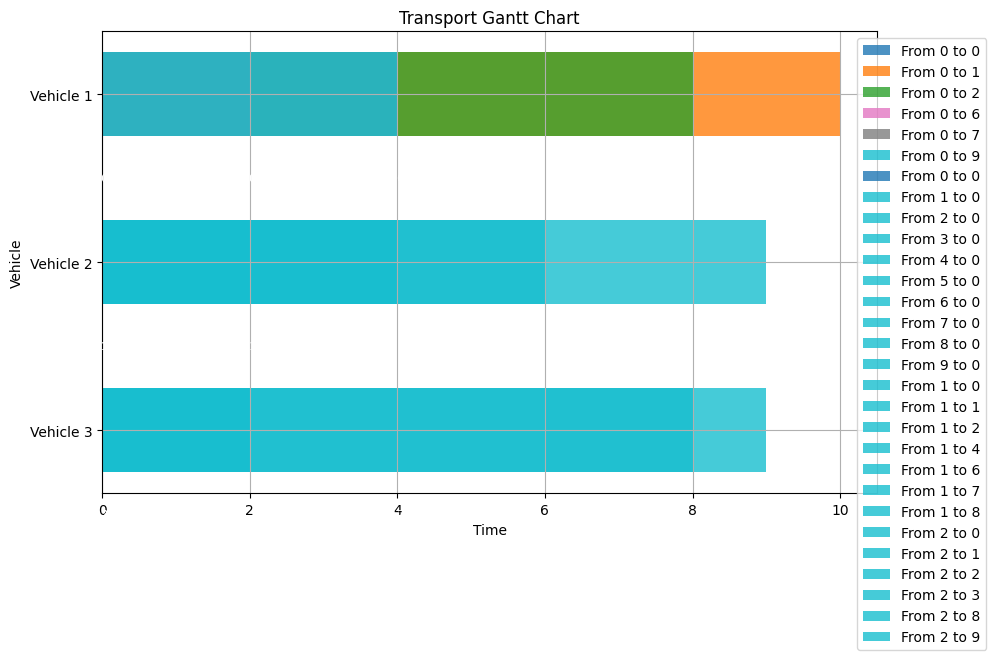

In [32]:
def plot_gantt_chart(result):
    # ガントチャート用のデータを準備
    tasks = []
    color_palette = plt.cm.get_cmap('tab10')

    # 各車両の輸送経路を抽出してガントチャート用のデータに追加
    for k in range(num_vehicles):
        task_start_times = []
        task_durations = []
        task_labels = []
        task_colors = []

        for t in range(num_time_periods):
            for p in range(num_destinations):
                for pp in range(num_destinations):
                    if result.first.sample['x[{0}][{1}][{2}][{3}]'.format(k,p,pp,t)] == 1:
                        task_start_times.append(t)
                        task_durations.append(travel_time.get((p, pp), 0))  # 地点間の移動時間を取得
                        task_labels.append(f'From {p} to {pp}')
                        task_colors.append(color_palette(p * num_destinations + pp))

        # ガントチャート用のデータに追加
        tasks.append((f'Vehicle {k+1}', task_start_times, task_durations, task_labels, task_colors))

    # ガントチャートのプロット
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (label, start_times, durations, labels, colors) in enumerate(tasks):
        for start, duration, label_text, color in zip(start_times, durations, labels, colors):
            ax.barh(label, duration, left=start, height=0.5, color=color, alpha=0.8, label=label_text)
            ax.text(start + duration / 2, i + 0.5, label_text, ha='center', va='center', color='white', fontsize=8)

    ax.set_xlabel('Time')
    ax.set_ylabel('Vehicle')
    ax.set_title('Transport Gantt Chart')
    ax.grid(True)
    ax.invert_yaxis()  # 車両の表示順を反転させる
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0))

    plt.show()

# ガントチャートの可視化
plot_gantt_chart(result)
